### Produce fractional ground cover (dry, green, litter, bare) models for CPER
Uses line-point intercept (LPI) ground data to train a Partial Least Squares (PLS) regression model 
to simlutaneously predict four ground cover fractions from satellite data


In [1]:
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneGroupOut, KFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler
from distributed import Client, LocalCluster

In [2]:
cluster = LocalCluster(n_workers=5, threads_per_worker=2)
client = Client(cluster)

In [18]:
def abline(slope, intercept, _ax=None, kws={}):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    if _ax is not None:
        _ax.plot(x_vals, y_vals, **kws)
    else:
        plt.plot(x_vals, y_vals, *kws)

In [4]:
#######################
### LOAD SAVED DATA ###
#######################
df_lpi = pd.read_csv("/mnt/d/CPER/data/vegetation/LPI_extractions/lpi_extraction_2013_2019.csv")
#df_lpi.drop(columns=['Unnamed: 0'], inplace=True)

var_names = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'dfi', 'ndvi', 'ndti', 'satvi', 'ndii7',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

In [5]:
##############################
### Prep data ###
##############################
df_lpi.dropna(axis=0, how='any', subset=var_names + ['pct_bare', 'pct_green', 'pct_litt',
                                                     'pct_sd', 'abs_sd', 'abs_green'], inplace=True)
band_list = var_names
df_lpi['pct_sd2'] = df_lpi['abs_sd'] / df_lpi['abs_cover'] * (df_lpi['pct_cover'])
df_lpi['pct_green2'] = df_lpi['abs_green'] / df_lpi['abs_cover'] * (df_lpi['pct_cover'])
df_lpi['ratio_bare'] = df_lpi['pct_bare'] / df_lpi['pct_cover']
df_lpi['ratio_green'] = df_lpi['pct_green'] / df_lpi['pct_cover']
df_lpi.reset_index(drop=True, inplace=True)

#df_lpi['Id_plot'] = df_lpi['Id'].apply(lambda x: x.split('_')[0] + '_' + x.split('_')[1])
#df_lpi = df_lpi.groupby(['Year', 'Id_plot']).agg('mean').reset_index()

df_lpi['rgb'] = list(zip(df_lpi['pct_sd2'], df_lpi['pct_green2'], df_lpi['pct_bare']))
df_lpi['rgb2'] = list(zip(df_lpi['pct_sd2'] + df_lpi['pct_litt'], df_lpi['pct_green2'], df_lpi['pct_bare']))

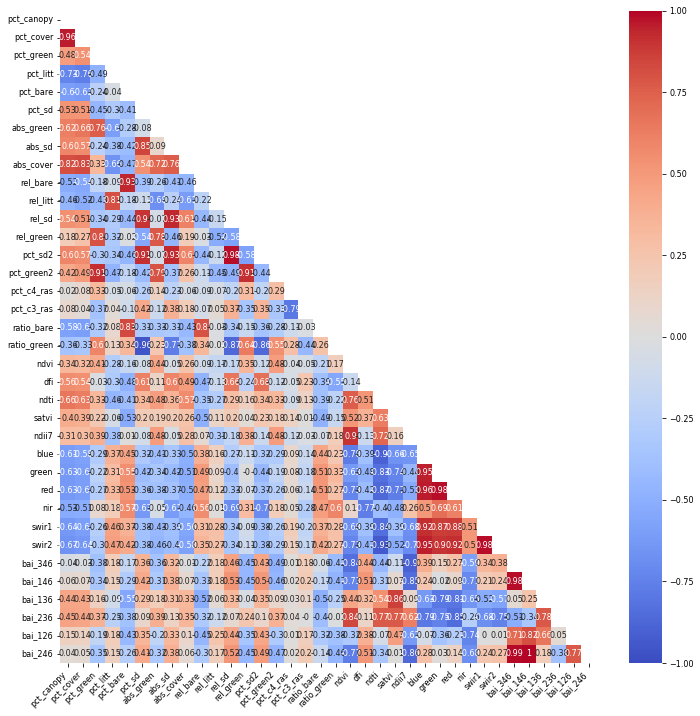

In [6]:
#################################
### Explore data with plots ###
#################################
"""
Figure: Correlation matrix for all variables
"""
# define variables for correlation matrix
cor_vars_all = df_lpi[['pct_canopy', 'pct_cover', 'pct_green', 'pct_litt', 'pct_bare', 'pct_sd',
                       'abs_green', 'abs_sd', 'abs_cover',
                       'rel_bare', 'rel_litt', 'rel_sd', 'rel_green', 
                       'pct_sd2', 'pct_green2', 'pct_c4_ras', 'pct_c3_ras',
                       'ratio_bare', 'ratio_green',
                       'ndvi', 'dfi', 'ndti', 'satvi', 'ndii7', 
                       'blue', 'green', 'red', 'nir', 'swir1', 'swir2', 
                       'bai_346', 'bai_146', 'bai_136', 'bai_236', 'bai_126', 'bai_246']]

# create and save correlation matrix
corrMatrix = np.round(cor_vars_all.reset_index(drop=True).corr(), 2)
mask = np.zeros(corrMatrix.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1, center=0, mask=mask, cmap='coolwarm',
                 annot_kws={"size": 8})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=8)

[Text(0.5, 0, 'Absolute green'), Text(0, 0.5, 'Relative green')]

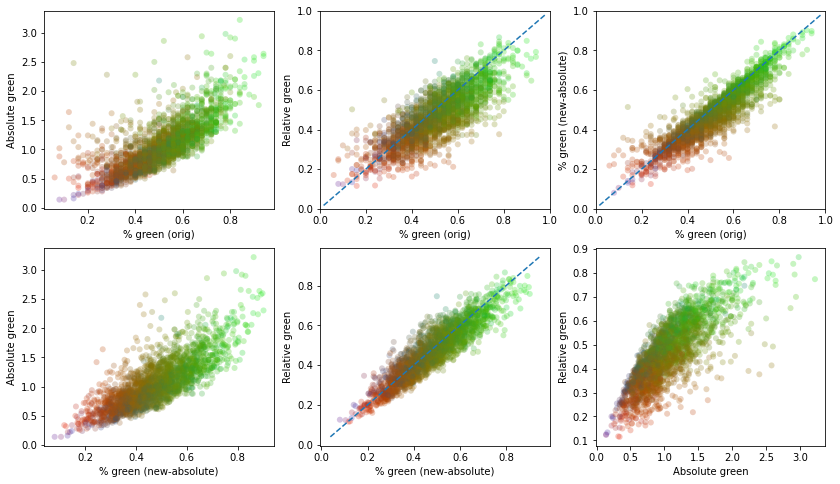

In [7]:
"""
Figure: Scatter plots of different greens
"""
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
ax[0, 0].scatter(x=df_lpi.pct_green, y=df_lpi.abs_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 0])
plt.gca().update(dict(xlabel='% green (orig)', ylabel='Absolute green'))

ax[0, 1].scatter(x=df_lpi.pct_green, y=df_lpi.rel_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 1])
abline(1, 0)
plt.gca().update(dict(xlabel='% green (orig)', ylabel='Relative green', ylim=(0, 1), xlim=(0, 1)))

ax[0, 2].scatter(x=df_lpi.pct_green, y=df_lpi.pct_green2, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 2])
abline(1, 0)
plt.gca().update(dict(xlabel='% green (orig)', ylabel='% green (new-absolute)', ylim=(0, 1), xlim=(0, 1)))

ax[1, 0].scatter(x=df_lpi.pct_green2, y=df_lpi.abs_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 0])
plt.gca().update(dict(xlabel='% green (new-absolute)', ylabel='Absolute green'))

ax[1, 1].scatter(x=df_lpi.pct_green2, y=df_lpi.rel_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 1])
abline(1, 0)
plt.gca().update(dict(xlabel='% green (new-absolute)', ylabel='Relative green'))

ax[1, 2].scatter(x=df_lpi.abs_green, y=df_lpi.rel_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 2])
plt.gca().update(dict(xlabel='Absolute green', ylabel='Relative green'))

[Text(0.5, 0, 'NDVI'), Text(0, 0.5, '% green (new)')]

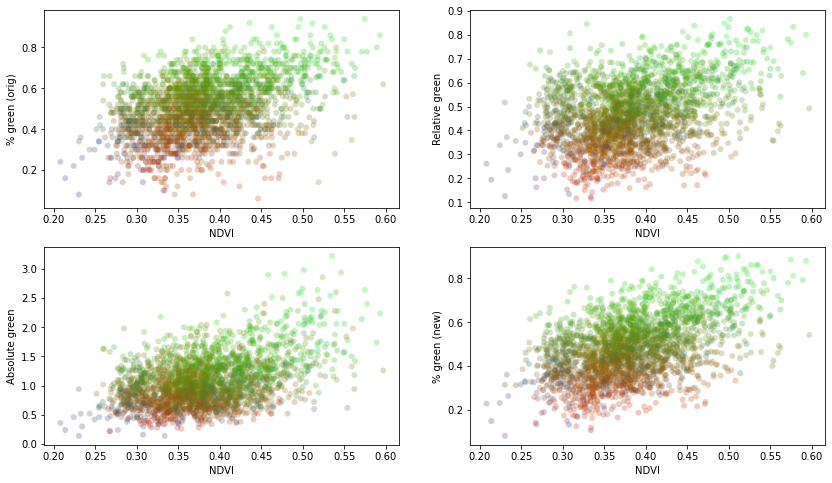

In [8]:
"""
Figure: Scatter plots of NDVI vs. different greens
"""
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
ax[0, 0].scatter(x=df_lpi.ndvi, y=df_lpi.pct_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 0])
plt.gca().update(dict(xlabel='NDVI', ylabel='% green (orig)'))

ax[0, 1].scatter(x=df_lpi.ndvi, y=df_lpi.rel_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 1])
plt.gca().update(dict(xlabel='NDVI', ylabel='Relative green'))

ax[1, 0].scatter(x=df_lpi.ndvi, y=df_lpi.abs_green, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 0])
plt.gca().update(dict(xlabel='NDVI', ylabel='Absolute green'))

ax[1, 1].scatter(x=df_lpi.ndvi, y=df_lpi.pct_green2, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 1])
plt.gca().update(dict(xlabel='NDVI', ylabel='% green (new)'))

[Text(0.5, 0, 'Absolute sd'), Text(0, 0.5, 'Relative sd')]

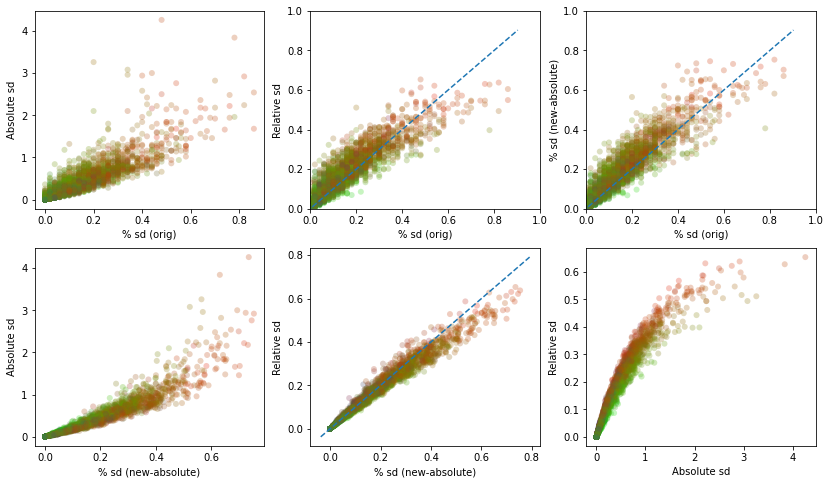

In [9]:
"""
Figure: Scatter plots of different sd's
"""
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
ax[0, 0].scatter(x=df_lpi.pct_sd, y=df_lpi.abs_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 0])
plt.gca().update(dict(xlabel='% sd (orig)', ylabel='Absolute sd'))

ax[0, 1].scatter(x=df_lpi.pct_sd, y=df_lpi.rel_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 1])
abline(1, 0)
plt.gca().update(dict(xlabel='% sd (orig)', ylabel='Relative sd', ylim=(0, 1), xlim=(0, 1)))

ax[0, 2].scatter(x=df_lpi.pct_sd, y=df_lpi.pct_sd2, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 2])
abline(1, 0)
plt.gca().update(dict(xlabel='% sd (orig)', ylabel='% sd (new-absolute)', ylim=(0, 1), xlim=(0, 1)))

ax[1, 0].scatter(x=df_lpi.pct_sd2, y=df_lpi.abs_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 0])
plt.gca().update(dict(xlabel='% sd (new-absolute)', ylabel='Absolute sd'))

ax[1, 1].scatter(x=df_lpi.pct_sd2, y=df_lpi.rel_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 1])
abline(1, 0)
plt.gca().update(dict(xlabel='% sd (new-absolute)', ylabel='Relative sd'))

ax[1, 2].scatter(x=df_lpi.abs_sd, y=df_lpi.rel_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 2])
plt.gca().update(dict(xlabel='Absolute sd', ylabel='Relative sd'))

[Text(0.5, 0, 'DFI'), Text(0, 0.5, '% sd (new)')]

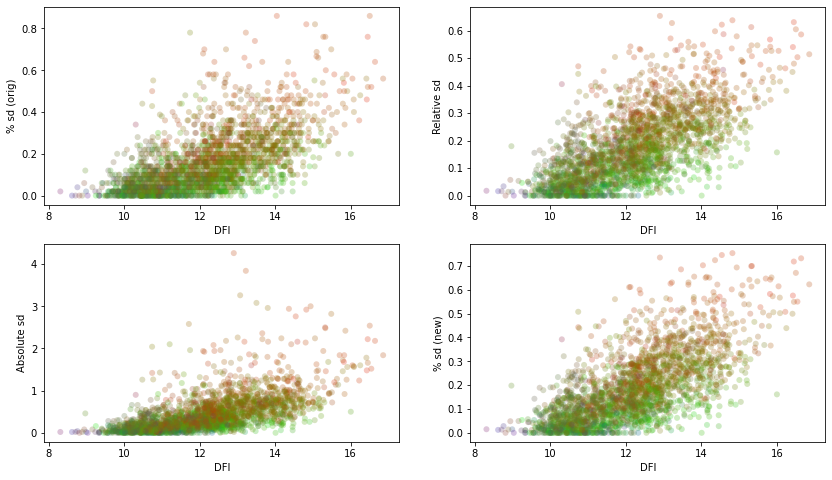

In [10]:
"""
Figure: Scatter plots of DFI vs. different sds
"""
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
ax[0, 0].scatter(x=df_lpi.dfi, y=df_lpi.pct_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 0])
plt.gca().update(dict(xlabel='DFI', ylabel='% sd (orig)'))

ax[0, 1].scatter(x=df_lpi.dfi, y=df_lpi.rel_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[0, 1])
plt.gca().update(dict(xlabel='DFI', ylabel='Relative sd'))

ax[1, 0].scatter(x=df_lpi.dfi, y=df_lpi.abs_sd, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 0])
plt.gca().update(dict(xlabel='DFI', ylabel='Absolute sd'))

ax[1, 1].scatter(x=df_lpi.dfi, y=df_lpi.pct_sd2, c=df_lpi['rgb2'], alpha=0.25, edgecolors='none')
plt.sca(ax[1, 1])
plt.gca().update(dict(xlabel='DFI', ylabel='% sd (new)'))

In [11]:
##############################
### Define variables ###
##############################
bare_col = 'pct_bare'
litt_col = 'pct_litt'
green_col = 'pct_green2'
sd_col = 'pct_sd2'

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


<AxesSubplot:xlabel='pct_litt', ylabel='pct_litt_pred'>

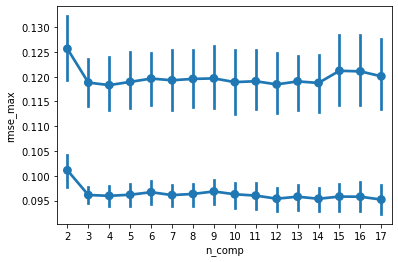

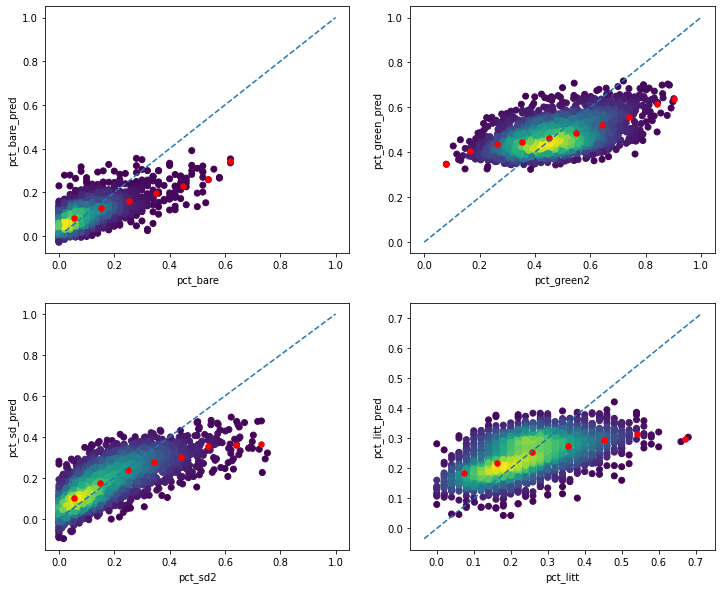

In [12]:
####################################
### PLS regression with all data ###
####################################
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

mod_logo = LeaveOneGroupOut()
mod_kfold = KFold(n_splits=10)
df_rmse = pd.DataFrame(columns=['n_comp', 'rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt'])
for i in range(2, len(band_list) + 1):
    print(i)
    rmse_bare, rmse_sd, rmse_green, rmse_litt = [], [], [], []
    for train_index, test_index in mod_kfold.split(df_lpi):
        X_tmp = df_lpi[band_list].iloc[train_index]
        X_tmp = PolynomialFeatures(2).fit_transform(X_tmp)
        # sc_tmp = StandardScaler()
        # sc_tmp.fit(X_tmp)
        # X_tmp[:] = sc_tmp.transform(X_tmp)
        y_tmp = df_lpi[[bare_col, sd_col, green_col, litt_col]].iloc[train_index].to_numpy()
        # y_tmp = np.log(1 + 100 * y_tmp)
        pls2 = PLSRegression(n_components=i, scale=True)
        pls2.fit(X_tmp, y_tmp)
        X_pred = df_lpi[band_list].iloc[test_index]
        X_pred = PolynomialFeatures(2).fit_transform(X_pred)
        # X_pred[:] = sc_tmp.transform(X_pred)
        Y_pred = pls2.predict(X_pred)
        # Y_pred = (np.exp(Y_pred) - 1) / 100
        rmse_bare.append(np.sqrt(np.mean((Y_pred[:, 0] - df_lpi[bare_col].iloc[test_index]) ** 2)))
        rmse_sd.append(np.sqrt(np.mean((Y_pred[:, 1] - df_lpi[sd_col].iloc[test_index]) ** 2)))
        rmse_green.append(np.sqrt(np.mean((Y_pred[:, 2] - df_lpi[green_col].iloc[test_index]) ** 2)))
        rmse_litt.append(np.sqrt(np.mean((Y_pred[:, 3] - df_lpi[litt_col].iloc[test_index]) ** 2)))
    ncomp = np.repeat(i, len(rmse_bare))
    df_tmp = pd.DataFrame({
        'n_comp': ncomp,
        'rmse_bare': rmse_bare,
        'rmse_sd': rmse_sd,
        'rmse_green': rmse_green,
        'rmse_litt': rmse_litt
    })
    df_rmse = df_rmse.append(df_tmp)

df_rmse['rmse_mean'] = df_rmse[['rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt']].mean(axis=1)
df_rmse['rmse_max'] = df_rmse[['rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt']].max(axis=1)
df_rmse['rmse_sum'] = df_rmse[['rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt']].sum(axis=1)
plt.figure()
sn.pointplot(x='n_comp', y='rmse_mean', data=df_rmse)
sn.pointplot(x='n_comp', y='rmse_max', data=df_rmse)
# sn.pointplot(x='n_comp', y='rmse_sum', data=df_rmse)

X = df_lpi[band_list]
# sc = StandardScaler()
# sc.fit(X)
# X.loc[:] = sc.transform(X)
X = PolynomialFeatures(2).fit_transform(X)
y = df_lpi[[bare_col, sd_col, green_col, litt_col]].to_numpy()
pls2 = PLSRegression(n_components=3, scale=True)
# pls2.fit(X, np.log(1 + 100 * y))
pls2.fit(X, y)
# Y_pred = model.predict(X)
# Y_pred = (np.exp(pls2.predict(X)) - 1) / 100
Y_pred = pls2.predict(X)
# Y_pred = (np.exp(pls2.predict(X)) - 1) / 100

df_lpi['pct_bare_pred'] = Y_pred[:, 0]
xy_bare_tmp = np.vstack([df_lpi[bare_col],
                         df_lpi['pct_bare_pred']])
df_lpi['z_pct_bare'] = gaussian_kde(xy_bare_tmp)(xy_bare_tmp)
df_lpi['pct_sd_pred'] = Y_pred[:, 1]
xy_sd_tmp = np.vstack([df_lpi[sd_col],
                       df_lpi['pct_sd_pred']])
df_lpi['z_pct_sd'] = gaussian_kde(xy_sd_tmp)(xy_sd_tmp)
df_lpi['pct_green_pred'] = Y_pred[:, 2]
xy_green_tmp = np.vstack([df_lpi[green_col],
                          df_lpi['pct_green_pred']])
df_lpi['z_pct_green'] = gaussian_kde(xy_green_tmp)(xy_green_tmp)
df_lpi['pct_litt_pred'] = Y_pred[:, 3]
xy_bare_tmp = np.vstack([df_lpi[litt_col],
                         df_lpi['pct_litt_pred']])
df_lpi['z_pct_litt'] = gaussian_kde(xy_bare_tmp)(xy_bare_tmp)

fig, ax3 = plt.subplots(figsize=(12, 10),
                        nrows=2, ncols=2)
ax3.flatten()[0].scatter(df_lpi[bare_col], df_lpi['pct_bare_pred'], c=df_lpi['z_pct_bare'])
ax3.flatten()[0].set_xlabel('Bare - observed')
ax3.flatten()[0].set_ylabel('Bare - predicted')
abline(1, 0, _ax=ax3.flatten()[0])
df_lpi.groupby(pd.cut(df_lpi[bare_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
    x=bare_col, y='pct_bare_pred', ax=ax3.flatten()[0], s=30, color=(1, 0, 0))

ax3.flatten()[1].scatter(df_lpi[green_col], df_lpi['pct_green_pred'], c=df_lpi['z_pct_green'])
ax3.flatten()[1].set_xlabel('Green - observed')
ax3.flatten()[1].set_ylabel('Green - predicted')
abline(1, 0, _ax=ax3.flatten()[1])
df_lpi.groupby(pd.cut(df_lpi[green_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
    x=green_col, y='pct_green_pred', ax=ax3.flatten()[1], s=30, color=(1, 0, 0))

ax3.flatten()[2].scatter(df_lpi[sd_col], df_lpi['pct_sd_pred'], c=df_lpi['z_pct_sd'])
ax3.flatten()[2].set_xlabel('SD - observed')
ax3.flatten()[2].set_ylabel('SD - predicted')
abline(1, 0, _ax=ax3.flatten()[2])
df_lpi.groupby(pd.cut(df_lpi[sd_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
    x=sd_col, y='pct_sd_pred', ax=ax3.flatten()[2], s=30, color=(1, 0, 0))

ax3.flatten()[3].scatter(df_lpi[litt_col], df_lpi['pct_litt_pred'], c=df_lpi['z_pct_litt'])
ax3.flatten()[3].set_xlabel('Litter - observed')
ax3.flatten()[3].set_ylabel('Litter - predicted')
abline(1, 0, _ax=ax3.flatten()[3])
df_lpi.groupby(pd.cut(df_lpi[litt_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
    x=litt_col, y='pct_litt_pred', ax=ax3.flatten()[3], s=30, color=(1, 0, 0))

In [13]:
########################################
### PLS regression with binned data ###
########################################
from sklearn.cross_decomposition import PLSRegression

df_lpi2 = df_lpi.copy(deep=True)
df_lpi2 = df_lpi2.groupby([
    pd.cut(df_lpi2[bare_col], np.arange(0, 1.1, 0.1)),
    pd.cut(df_lpi2[sd_col], np.arange(0, 1.1, 0.1)),
    pd.cut(df_lpi2[green_col], np.arange(0, 1.1, 0.1)),
    pd.cut(df_lpi2[litt_col], np.arange(0, 1.1, 0.1))]).mean().reset_index(drop=True)
df_lpi2 = df_lpi2.dropna(axis=0)
df_lpi2['rgb'] = list(zip(df_lpi2[sd_col], df_lpi2[green_col], df_lpi2[bare_col]))
df_lpi2['rgb2'] = list(zip(df_lpi2[sd_col] + df_lpi2[litt_col], df_lpi2[green_col], df_lpi2[bare_col]))
# sc2 = StandardScaler()
# sc2.fit(df_lpi2[band_list])
# df_lpi2[band_list] = sc2.transform(df_lpi2[band_list])

mod_logo = LeaveOneGroupOut()
mod_kfold = KFold(n_splits=10)
df_rmse = pd.DataFrame(columns=['n_comp', 'rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt'])
for i in range(2, len(band_list) + 1):
    print(i)
    rmse_bare, rmse_sd, rmse_green, rmse_litt = [], [], [], []
    for train_index, test_index in mod_kfold.split(df_lpi):
        df_lpi_tmp = df_lpi.iloc[train_index].copy(deep=True)
        df_lpi_grp_tmp = df_lpi_tmp.groupby([
            pd.cut(df_lpi_tmp[bare_col], np.arange(0, 1.1, 0.1)),
            pd.cut(df_lpi_tmp[sd_col], np.arange(0, 1.1, 0.1)),
            pd.cut(df_lpi_tmp[green_col], np.arange(0, 1.1, 0.1)),
            pd.cut(df_lpi_tmp[litt_col], np.arange(0, 1.1, 0.1))]).mean().reset_index(drop=True)
        df_lpi_grp_tmp = df_lpi_grp_tmp.dropna(axis=0)
        # sc2_tmp = StandardScaler()
        # sc2_tmp.fit(df_lpi_grp_tmp[band_list])
        # df_lpi_grp_tmp[band_list] = sc2_tmp.transform(df_lpi_grp_tmp[band_list])
        X_tmp = df_lpi_grp_tmp[band_list]
        X_tmp = PolynomialFeatures(2).fit_transform(X_tmp)
        y_tmp = df_lpi_grp_tmp[[bare_col, sd_col, green_col, litt_col]].to_numpy()
        # y_tmp = np.log(1 + 100 * y_tmp)
        pls2 = PLSRegression(n_components=i, scale=False)
        pls2.fit(X_tmp, y_tmp)
        X_pred = df_lpi[band_list].iloc[test_index]
        # X_pred[:] = sc2_tmp.transform(X_pred)
        X_pred = PolynomialFeatures(2).fit_transform(X_pred)
        Y_pred = pls2.predict(X_pred)
        # Y_pred = (np.exp(Y_pred) - 1) / 100
        rmse_bare.append(np.sqrt(np.mean((Y_pred[:, 0] - df_lpi[bare_col].iloc[test_index]) ** 2)))
        rmse_sd.append(np.sqrt(np.mean((Y_pred[:, 1] - df_lpi[sd_col].iloc[test_index]) ** 2)))
        rmse_green.append(np.sqrt(np.mean((Y_pred[:, 2] - df_lpi[green_col].iloc[test_index]) ** 2)))
        rmse_litt.append(np.sqrt(np.mean((Y_pred[:, 3] - df_lpi[litt_col].iloc[test_index]) ** 2)))
    ncomp = np.repeat(i, len(rmse_bare))
    df_tmp = pd.DataFrame({
        'n_comp': ncomp,
        'rmse_bare': rmse_bare,
        'rmse_sd': rmse_sd,
        'rmse_green': rmse_green,
        'rmse_litt': rmse_litt
    })
    df_rmse = df_rmse.append(df_tmp)

df_rmse['rmse_mean'] = df_rmse[['rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt']].mean(axis=1)
df_rmse['rmse_max'] = df_rmse[['rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt']].max(axis=1)
df_rmse['rmse_sum'] = df_rmse[['rmse_bare', 'rmse_sd', 'rmse_green', 'rmse_litt']].sum(axis=1)
plt.figure()
sn.pointplot(x='n_comp', y='rmse_mean', data=df_rmse)
sn.pointplot(x='n_comp', y='rmse_max', data=df_rmse)
# sn.pointplot(x='n_comp', y='rmse_sum', data=df_rmse)

In [37]:
X = df_lpi2[band_list]
X = PolynomialFeatures(2).fit_transform(X)
y = df_lpi2[[bare_col, sd_col, green_col, litt_col]].to_numpy()
pls2 = PLSRegression(n_components=4, scale=False)
# pls2.fit(X, np.log(1 + 100 * y))
pls2.fit(X, y)
# Y_pred = model.predict(X)
# Y_pred = (np.exp(pls2.predict(X)) - 1) / 100

PLSRegression(n_components=4, scale=False)

In [38]:
X2 = df_lpi[band_list]
X2 = PolynomialFeatures(2).fit_transform(X2)
# X2.loc[:] = sc2.transform(X2)
Y_pred = pls2.predict(X2)
# Y_pred = (np.exp(pls2.predict(X2)) - 1) / 100
Y_pred[Y_pred < 0] = 0
Y_pred[Y_pred > 1] = 1

df_lpi['pct_bare_pred'] = Y_pred[:, 0] / np.sum(Y_pred, axis=1)
df_lpi['pct_sd_pred'] = Y_pred[:, 1] / np.sum(Y_pred, axis=1)
df_lpi['pct_green_pred'] = Y_pred[:, 2] / np.sum(Y_pred, axis=1)
df_lpi['pct_litt_pred'] = Y_pred[:, 3] / np.sum(Y_pred, axis=1)

xy_bare_tmp = np.vstack([df_lpi['pct_bare_pred'], df_lpi[bare_col]])
df_lpi['z_pct_bare'] = gaussian_kde(xy_bare_tmp)(xy_bare_tmp)
xy_sd_tmp = np.vstack([df_lpi['pct_sd_pred'], df_lpi[sd_col]])
df_lpi['z_pct_sd'] = gaussian_kde(xy_sd_tmp)(xy_sd_tmp)
xy_green_tmp = np.vstack([df_lpi['pct_green_pred'], df_lpi[green_col]])
df_lpi['z_pct_green'] = gaussian_kde(xy_green_tmp)(xy_green_tmp)
xy_bare_tmp = np.vstack([df_lpi['pct_litt_pred'], df_lpi[litt_col]])
df_lpi['z_pct_litt'] = gaussian_kde(xy_bare_tmp)(xy_bare_tmp)

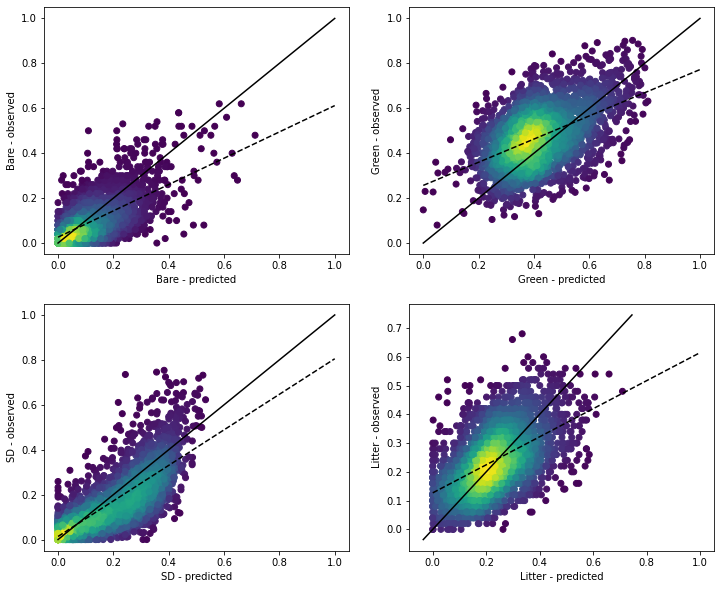

In [43]:
fig, ax3 = plt.subplots(figsize=(12, 10),
                        nrows=2, ncols=2)
ax3.flatten()[0].scatter(df_lpi['pct_bare_pred'], df_lpi[bare_col],  c=df_lpi['z_pct_bare'])
ax3.flatten()[0].set_ylabel('Bare - observed')
ax3.flatten()[0].set_xlabel('Bare - predicted')
abline(1, 0, _ax=ax3.flatten()[0], kws=dict(color='black'))
b, a = np.polyfit(df_lpi['pct_bare_pred'], df_lpi[bare_col], deg=1)
xseq = np.linspace(0, 1, num=20)
ax3.flatten()[0].plot(xseq, a + b * xseq, color="k", linestyle='--')
#df_lpi.groupby(pd.cut(df_lpi[bare_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
#    y=bare_col, x='pct_bare_pred', ax=ax3.flatten()[0], s=30, color=(1, 0, 0))

ax3.flatten()[1].scatter(df_lpi['pct_green_pred'], df_lpi[green_col],  c=df_lpi['z_pct_green'])
ax3.flatten()[1].set_ylabel('Green - observed')
ax3.flatten()[1].set_xlabel('Green - predicted')
abline(1, 0, _ax=ax3.flatten()[1], kws=dict(color='black'))
b, a = np.polyfit(df_lpi['pct_green_pred'], df_lpi[green_col], deg=1)
xseq = np.linspace(0, 1, num=20)
ax3.flatten()[1].plot(xseq, a + b * xseq, color="k", linestyle='--')
#df_lpi.groupby(pd.cut(df_lpi[green_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
#    y=green_col, x='pct_green_pred', ax=ax3.flatten()[1], s=30, color=(1, 0, 0))

ax3.flatten()[2].scatter(df_lpi['pct_sd_pred'], df_lpi[sd_col],  c=df_lpi['z_pct_sd'])
ax3.flatten()[2].set_ylabel('SD - observed')
ax3.flatten()[2].set_xlabel('SD - predicted')
abline(1, 0, _ax=ax3.flatten()[2], kws=dict(color='black'))
b, a = np.polyfit(df_lpi['pct_sd_pred'], df_lpi[sd_col], deg=1)
xseq = np.linspace(0, 1, num=20)
ax3.flatten()[2].plot(xseq, a + b * xseq, color="k", linestyle='--')
#df_lpi.groupby(pd.cut(df_lpi[sd_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
#    y=sd_col, x='pct_sd_pred', ax=ax3.flatten()[2], s=30, color=(1, 0, 0))

ax3.flatten()[3].scatter(df_lpi['pct_litt_pred'], df_lpi[litt_col],  c=df_lpi['z_pct_litt'])
ax3.flatten()[3].set_ylabel('Litter - observed')
ax3.flatten()[3].set_xlabel('Litter - predicted')
abline(1, 0, _ax=ax3.flatten()[3], kws=dict(color='black'))
b, a = np.polyfit(df_lpi['pct_litt_pred'], df_lpi[litt_col], deg=1)
xseq = np.linspace(0, 1, num=20)
ax3.flatten()[3].plot(xseq, a + b * xseq, color="k", linestyle='--')
#df_lpi.groupby(pd.cut(df_lpi[litt_col], np.arange(0, 1.1, 0.1))).mean().reset_index(drop=True).plot.scatter(
#    y=litt_col, x='pct_litt_pred', ax=ax3.flatten()[3], s=30, color=(1, 0, 0))

In [15]:
band_list

['blue',
 'green',
 'red',
 'nir',
 'swir1',
 'swir2',
 'dfi',
 'ndvi',
 'ndti',
 'satvi',
 'ndii7',
 'bai_126',
 'bai_136',
 'bai_146',
 'bai_236',
 'bai_246',
 'bai_346']